In [1]:
import gzip
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, \
                                    Activation, Dropout, MaxPooling2D

def evaluate(path, model):
    X, y = pickle.load(gzip.open(path, 'rb'))
    y[y != 0] -= 2
    X = X / 255.
    acc = np.mean(model(X).numpy().argmax(axis=1) == y)
    return acc


In [2]:
path = 'flatland_train.data'
X,y = pickle.load(gzip.open(path,'rb')) 

# data pre-proc
y[y != 0] -= 2
X = X.reshape (X.shape[0],50,50,1) / 255.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

DNN modelis

In [4]:
# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=[50, 50]))
# model.add(keras.layers.Dense(64, activation="relu"))
# model.add(keras.layers.Dense(32, activation="relu"))
# model.add(keras.layers.Dense(10, activation="softmax"))
# model.compile(loss="sparse_categorical_crossentropy",
#               optimizer="Adam",
#               metrics=["accuracy"])
# model.summary()

**CNN modelis**

Atlikome daug testinių modelių (kuriuos galima rasti mano github: Kulikauskas07) ir sudarėme CNN modelį, kuris tenkina geriausią tikslumą. Pastebėjome, jog geriausia yra naudoti konvoliucinius sluoksnius, Maxpooling'ą, kuris mažina sluoksnius ir padeda geriau treniruotis, taip pat pastebėjome, jog naudinga naudoti Dropout, kadangi jis atmeta "per gerus (Outliers)" neutronus bei keletą kitų sluoksnių. Optimizacijai naudojome "Adams" paketą, kuris yra žymiai efektyvesnis nei "sgd". Ir dar buvo svarbu "early stopping", todėl ėmėme 7-10 epoch.

In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[50, 50, 1]))
model.add(keras.layers.BatchNormalization(axis=-1)) 
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization(axis=-1)) 
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization(axis=-1)) 
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization(axis=-1)) 
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(Flatten())
model.add(Dropout(0.5))

model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dense(56, activation="relu"))

model.add(keras.layers.Dense(12, activation='softmax'))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_16 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 batch_normalization_17 (Bat  (None, 22, 22, 64)       256       
 chNormalization)                                                
                                                      

In [17]:
loss = model.fit(X_train, y_train, epochs=7,validation_data=[X_test,y_test])


Epoch 1/7
219/219 [==============================] - 5s 17ms/step - loss: 1.1927 - accuracy: 0.5476 - val_loss: 4.7931 - val_accuracy: 0.1520
Epoch 2/7
219/219 [==============================] - 3s 15ms/step - loss: 0.4358 - accuracy: 0.8539 - val_loss: 3.9996 - val_accuracy: 0.2100
Epoch 3/7
219/219 [==============================] - 3s 15ms/step - loss: 0.2649 - accuracy: 0.9276 - val_loss: 0.3673 - val_accuracy: 0.8720
Epoch 4/7
219/219 [==============================] - 3s 15ms/step - loss: 0.2106 - accuracy: 0.9469 - val_loss: 0.2536 - val_accuracy: 0.9270
Epoch 5/7
219/219 [==============================] - 3s 15ms/step - loss: 0.1628 - accuracy: 0.9667 - val_loss: 0.2208 - val_accuracy: 0.9473
Epoch 6/7
219/219 [==============================] - 3s 15ms/step - loss: 0.1363 - accuracy: 0.9720 - val_loss: 0.1694 - val_accuracy: 0.9720
Epoch 7/7
219/219 [==============================] - 3s 15ms/step - loss: 0.1325 - accuracy: 0.9724 - val_loss: 0.1594 - val_accuracy: 0.9780


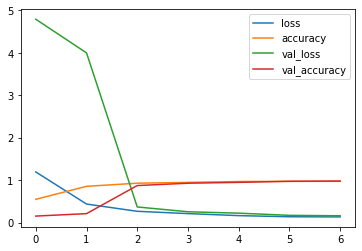

In [18]:
pd.DataFrame(loss.history).plot()


In [19]:
model.save('model_cnnFINAL.h5')


In [20]:
model = keras.models.load_model('model_cnnFINAL.h5')
evaluate('flatland_train.data', model)

0.9821

In [21]:
pred_ = model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred_ == y_test).mean()))

Accuracy on test set - 97.80%
